# Tarea 3: Regularización y Optimización <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas
## Nombre: Matias Vergara Silva

**Fecha de entrega: 13 de noviembre de 2020**


In [33]:
# Preliminar: Cargamos funciones de la Pauta de la Tarea 2.
# Los gradientes se pueden implementar como parte de cada una de las funciones de activación
# En el caso de swish y celu devuelven una tupla (d_dx, d_dp)

def sig(T, gradient=False):
  if gradient:
    sigT = sig(T)
    return sigT * (1 - sigT)
  return torch.reciprocal(1 + torch.exp(-1 * T))
  
def tanh(T, gradient=False):
  if gradient:
    tanhT = tanh(T)
    return 1 - tanhT * tanhT
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

def relu(T, gradient=False):
  if gradient:
    outT = torch.zeros_like(T)
    outT[T>=0] = 1
    return outT
  return torch.max(T, torch.zeros_like(T))

def swish(T, beta=1, gradient=False):
  if gradient:
    sigbT = sig(beta * T)
    swishT = T * sigbT
    return sigbT + beta * swishT * (1 - sigbT), swishT * (T - swishT)
  return T * torch.reciprocal(1 + torch.exp(-beta * T))

def celu(T, alpha=1, gradient=False):
  if alpha == 0:
    raise ValueError("alpha cannot be 0")

  zeros = torch.zeros_like(T)
  Talpha = T / alpha
  
  if gradient:
    e = Talpha.exp()
    d_dx = torch.ones_like(T)
    d_dx[T<0] = e[T<0]
    zeros[T<0] = (celu(T)[T<0] - T[T<0] * e[T<0]) / alpha
    return d_dx, zeros # d_dx, d_da
  
  return torch.max(zeros, T) + torch.min(zeros, alpha * (Talpha).expm1())

def softmax(T, dim, estable=True):
  if estable:
    T -= T.max(dim=dim, keepdim=True)[0]  # keepdim=True => output has dim with size 1. Otherwise, dim is squeezed
  exp = torch.exp(T)
  return exp / torch.sum(exp, dim=dim, keepdim=True)  # keepdim=True => output has dim with size 1. Otherwise, dim is squeezed

# Preliminar: Traemos CELoss de la Pauta de la T2
def CELoss(Q, P, estable=True, epsilon=1e-8):
  N = Q.shape[0]
  if estable:
    Q = Q.clamp(epsilon, 1-epsilon)
  return -(P * Q.log()).sum()/N

In [34]:
# Este notebook está pensado para correr en CoLaboratory. 
# Lo único imprescindible por importar es torch
import torch

# Posiblemenete quieras instalar e importar ipdb para debuggear.
# Si es así, descomenta lo siguiente:
# !pip install -q ipdb
# import ipdb

# Aqui instalamos la libreria de correccion del curso
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-zlc4qe66/cc6204
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-zlc4qe66/cc6204
  Created wheel for cc6204: filename=cc6204-0.5.0-cp36-none-any.whl size=5801 sha256=b0886743aec8048c2f166bb7de777f95ccd31d266a8af73c74236fd28bd4c6ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-4tkxweyl/wheels/62/f0/30/aadcb7ce24a2f9c935890518e902d4e23bf97b80f47bb64414
Successfully built cc6204
  Found existing installation: cc6204 0.5.0
    Uninstalling cc6204-0.5.0:
      Successfully uninstalled cc6204-0.5.0


In [35]:
# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# ingresa el host y port que posteamos en u-cursos
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# anota el token que te daremos en u-cursos
token = "]ye/Ox;nsz"

Connection stablished


# Parte 1: Regularización y Generalización



## 1a) Regularización por *weight decay*

In [36]:
class SGD():
  def __init__(self, parameters, lr, beta=0):
    self.params = [p for p in parameters if p is not None]
    self.lr = lr
    self.beta = beta

  
  def step(self):
    for i in range(0, len(self.params)):
      if self.params[i].dim()>1:
        self.params[i].data = (1 - self.beta)*self.params[i].data - (self.lr * self.params[i].grad)
      else:
        self.params[i].data -= self.params[i].grad * self.lr

In [37]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="1a", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = SGD([weight], lr=0.1, beta=0.1)
optimizer.step()

# Submit
corrector.submit(homework=3, question="1a", test=1, token=token, answer=weight)

Correct Test!


## 1b) Regularización por dropout

Para esta parte de la tarea, va a ser necesario modificar el método `forward` para que entregue el valor a la salida de la i-esima capa escondida. Para esto se modifica el método forward para que reciba un parámetro `output_layer` que indica luego de que capa escondida se espera el output.

In [38]:
# Tu código debiera continuar como sigue
import torch.nn as nn
from torch.nn import Parameter, ParameterList
import math


def get_init_weights(shape):
  W = torch.randn(shape)
  # stdv = 1. / math.sqrt(W.size(1))
  # W.data.uniform_(-stdv, stdv)
  return Parameter(W)


def xavier_init(first_dim, second_dim, r=None):
  ones = torch.ones((first_dim, second_dim))
  zeros = torch.zeros((first_dim, second_dim))
  dim1 = ones * first_dim
  if r == None:
    W = torch.normal(mean = zeros, std = ones)
    W = W * torch.sqrt(torch.reciprocal(dim1))
    return W
  return r*torch.sqrt(torch.reciprocal(dim1))


def he_init(first_dim, second_dim, r=None):
  ones = torch.ones((first_dim, second_dim))
  twos = 2 * ones
  zeros = torch.zeros((first_dim, second_dim))
  dim1 = ones * first_dim
  if r == None:
    W = torch.normal(mean = zeros, std = ones)
    W = W * torch.sqrt(twos * torch.reciprocal(dim1))
    return W
  return r * torch.sqrt(twos * torch.reciprocal(dim1))

class FFNN(nn.Module):
  def __init__(self, F, l_h, l_a, C, l_a_params=None, keep_prob=None, init = None):
    super(FFNN, self).__init__()
    sizes = [F] + l_h + [C]
    if init == None:
      self.Ws = ParameterList([get_init_weights((sizes[i], sizes[i+1])) for i in range(len(sizes)-1)])
    elif init == 'xavier':
      self.Ws = ParameterList([])
      self.Ws.append(Parameter(xavier_init(sizes[0], sizes[1])))
      for i in range(1, len(sizes)-1):
        if l_a[i-1]!=relu:
          self.Ws.append(Parameter(xavier_init(sizes[i], sizes[i+1])))
        else:
          self.Ws.append(Parameter(he_init(sizes[i], sizes[i+1])))
    self.bs = ParameterList([Parameter(torch.zeros(h)) for h in sizes[1:]])
    self.fs = l_a
    if l_a_params is not None:
      self.fs_ps_mask = [Parameter(torch.tensor(p)) if p else None for p in l_a_params]
    else:
      self.fs_ps_mask = [None for _ in l_a]
    self.fs_ps = ParameterList([p for p in self.fs_ps_mask if p])
        # Lo unico 'nuevo' que necesitamos guardar es el parámetro keep_prob. 
    if keep_prob is not None:
      self.keep_prob = [Parameter(torch.tensor(p)) if p else None for p in keep_prob]
      if any(keep_prob) < 0 or any(keep_prob) > 1:
            raise ValueError("Las probabilidades de dropout, keep_prob, deben estar entre\
                              0 y 1, pero se leyó{} .".format(keep_prob))   


  
  def forward(self, x, predict=False, output_layer=None):    
    self.masks = []
    self.cacheU = [] 
    if predict:
      self.keep_prob=[]
      for i in range(0, len(self.fs)+1):
        self.keep_prob.append(1.0)
    count = 0
    i_prob = 0
    # Primera mascara: para la entrada
    mask = torch.distributions.bernoulli.Bernoulli(probs=self.keep_prob[i_prob])
    mask_sample = torch.squeeze(mask.sample(x.size()))
    mask_sample_p = mask_sample * (torch.reciprocal(torch.ones_like(mask_sample)*self.keep_prob[i_prob]))
    mask_sample_p = mask_sample_p.to(x.device)
    self.masks.append(mask_sample_p)
    # multiplicar por la capa de bits / probabilidad 
    #x = x * mask_sample_p
    count += 1
    i_prob += 1
    
    # Implementación de forward
    for W, b, f, p in zip(self.Ws[:-1], self.bs[:-1], self.fs, self.fs_ps_mask):
      x = torch.mm(x, W) + b
      self.cacheU.append(x)
      x = f(x, p.item()) if p else f(x)
      #mascaras del ciclo
      mask = torch.distributions.bernoulli.Bernoulli(probs=self.keep_prob[i_prob])
      mask_sample = torch.squeeze(mask.sample(x.size()))
      mask_sample_p = mask_sample * (torch.reciprocal(torch.ones_like(mask_sample)*self.keep_prob[i_prob]))
      mask_sample_p = mask_sample_p.to(x.device)
      self.masks.append(mask_sample_p)
      # multiplicar por la capa de bits 
      x = x*mask_sample_p
      i_prob += 1
    if output_layer is not None:
      if count == output_layer +1 :
        return x
      count+=1
    output = softmax(torch.mm(x, self.Ws[-1]) + self.bs[-1], dim=1)
    return output  
  
  def backward(self, x, y, y_pred):
    current_grad = ((y_pred-y)/y.size(0))    

    for i in range(len(self.Ws)-1, 0, -1):
      if self.fs_ps_mask[i-1] is None:
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1]).t() @ current_grad

      else:
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1].item()).t()  @ current_grad
      self.bs[i].grad = current_grad.sum(dim=0)
      h_grad = current_grad @ self.Ws[i].t()
      # MODIFICADO PARA CONSIDERAR LA MASCARA BINOMIAL CORRESPONDIENTE
      factor = self.masks[i]
      factor = factor.to(h_grad.device)
      h_grad = h_grad * factor
      
      if self.fs_ps_mask[i-1] is None:
        current_grad = self.fs[i-1](self.cacheU[i-1], gradient=True) * h_grad

      else:
        current_grad, p_grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1], gradient=True)
        current_grad *= h_grad 
        self.fs_ps_mask[i-1].grad = (p_grad * h_grad).sum()
    
    self.Ws[0].grad = x.t() @ current_grad
    self.bs[0].grad = current_grad.sum(dim=0)

In [39]:
# Tests del API del curso
torch.manual_seed(0)
sample = torch.rand(1, 10)
red = FFNN(10, [1000], [sig], 1, keep_prob=[1.0, 0.5])
y = red(sample, output_layer=0)
output_mask = (y == 0)
percent = torch.sum(output_mask).item() / list(output_mask.size())[-1]
print("Percent init=None: ", percent)
# Submit
corrector.submit(homework=3, question="1b", test=1, token=token, answer=percent)

#probando los otros iniciadores
red == FFNN(10, [1000], [sig], 1, keep_prob=[1.0, 0.5], init='xavier')
y = red(sample, output_layer=0)
output_mask = (y == 0)
percent = torch.sum(output_mask).item() / list(output_mask.size())[-1]
print("Percent init=xavier: ", percent)
# Submit
corrector.submit(homework=3, question="1b", test=1, token=token, answer=percent)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Percent init=None:  0.528
Correct Test!
Percent init=xavier:  0.508
Correct Test!


## 1c) Entrenamiento y generalización sobre MNIST 

In [40]:
# Importamos MNIST desde torchvision.
from torchvision.datasets import MNIST

# Importamos una función para convertir imágenes en tensores.
from torchvision.transforms import ToTensor

# Descarga y almacena el conjunto de prueba de MNIST.
mnist_train_dataset = MNIST('mnist', train=True, transform=ToTensor(), download=True)
mnist_test_dataset = MNIST('mnist', train=False, transform=ToTensor(), download=True)
print('Cantidad total de datos de entrenamiento:',len(mnist_train_dataset))
print('Cantidad total de datos de prueba:',len(mnist_test_dataset))

import sys

Cantidad total de datos de entrenamiento: 60000
Cantidad total de datos de prueba: 10000


In [6]:
# odigo para entrenar en MNIST
# Codigo modificado a partir de la pauta Tarea 2
def entrenar_FFNN(red, dataset, optimizador, epochs=1, batch_size=1, reports_every=1, device='cpu'):
  red.to(device)
  data = DataLoader(dataset, batch_size, shuffle=True)
  total=len(dataset)
  tiempo_epochs = 0
  loss, acc = [], []
  for e in range(1,epochs+1):  
    inicio_epoch = timer()
    
    for x, y in data:
      x, y = x.view(x.size(0), -1).float().to(device), y.to(device)
      
      y_pred = red.forward(x, predict = False)
      y_onehot = torch.zeros_like(y_pred)
      y_onehot[torch.arange(x.size(0)), y] = 1.

      red.backward(x, y_onehot, y_pred)
      
      optimizador.step()
    
    tiempo_epochs += timer() - inicio_epoch
    
    
    if e % reports_every == 0:
      X = dataset.data.view(len(dataset), -1).float().to(device)
      Y = dataset.targets.to(device)
      
      Y_PRED = red.forward(X, predict = True).to(device)
      
      Y_onehot = torch.zeros_like(Y_PRED)
      Y_onehot[torch.arange(X.size(0)), Y] = 1.

      L_total = CELoss(Y_PRED, Y_onehot)
      loss.append(L_total)
      diff = Y-torch.argmax(Y_PRED,1)
      errores = torch.nonzero(diff).size(0)
      
      Acc=100*(total-errores)/total
      acc.append(Acc)

      sys.stdout.write(
            '\rEpoch:{0:03d}'.format(e) + ' Acc:{0:.2f}%'.format(Acc)
            + ' Loss:{0:.4f}'.format(L_total) 
            + ' Tiempo/epoch:{0:.3f}s'.format(tiempo_epochs/e))
  
  return loss, acc


In [7]:
# Código de la Tarea 2 para graficar los resultados. 
# Lo modificamos para comparar el resultado con y sin weight decay.

import matplotlib.pyplot as plt

def plot_results_mod(id1, id2, loss1, loss2, acc1,  acc2):
  f3 = plt.figure(id1)
  ax1 = f3.add_subplot(111)
  ax1.set_title("Loss Comparation")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss1, c='r', label="Without Weight Decay")
  ax1.plot(loss2, c='b', label="With Weight Decay")
  ax1.legend()
  
  f3.show()

  f4 = plt.figure(id2)
  ax2 = f4.add_subplot(111)
  ax2.set_title("Accuracy Comparation")     
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('acc')
  ax2.plot(acc1, c='r', label="Without Weight Decay")
  ax2.plot(acc2, c='b', label="Whit Weight Decay ")
  ax2.legend()
  f4.show()


In [14]:
from torch.utils.data import Dataset, DataLoader
from timeit import default_timer as timer

In [18]:
# Entrenamos nuestra red con MNIST 
# Probaremos con y sin weight decay, para poder evidenciar su influencia.

mnist_model_a = FFNN(784, [1024, 2048, 512], [relu, relu, relu], 10, keep_prob=[1.0, 0.8, 0.8, 1.0])
mnist_model_b = FFNN(784, [1024, 2048, 512], [relu, relu, relu], 10, keep_prob=[1.0, 0.8, 0.8, 1.0])

mnist_optimizer_NOWD = SGD(mnist_model_a.parameters(), lr=1e-5 )
mnist_optimizer_WD = SGD(mnist_model_b.parameters(), lr=1e-5, beta = 0.00001)

with torch.no_grad():
  #loss1, acc1 = entrenar_FFNN(mnist_model_a, mnist_train_dataset, mnist_optimizer_NOWD, epochs=30, batch_size=32, device='cuda', reports_every=3)
  loss2, acc2 = entrenar_FFNN(mnist_model_b, mnist_train_dataset, mnist_optimizer_WD, epochs=30, batch_size=32, device='cuda', reports_every=3)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Epoch:030 Acc:98.03% Loss:0.3635 Tiempo/epoch:14.171s

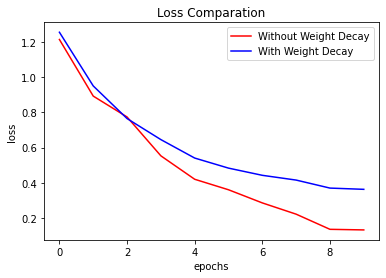

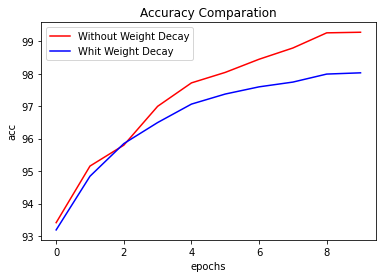

In [19]:
plot_results_mod(1, 2, loss1, loss2,  acc1, acc2)

Observamos que el Weight Decay implementado empeora considerablemente las métricas en testing. 

(No logré graficar en training uwu la idea de esta parte era ver que el loss de validación y de training decaen juntos al usar weight-decay, en lugar de separarse tempranamente).

# Parte 2: Optimización

## 2a) Inicialización de Xavier/He

Para los test de esta parte vamos a necesitar que modifiques tu código para que se pueda entregar valores predeterminados de `r`. Ahora tu código para las inicializaciones debe ser: `xavier_init(first_dim, second_dim, r=None)`, `he_init(first_dim, second_dim, r=None)`.

In [41]:
# Tu código debiera continuar como sigue

def xavier_init(first_dim, second_dim, r=None):
  ones = torch.ones((first_dim, second_dim))
  zeros = torch.zeros((first_dim, second_dim))
  dim1 = ones * first_dim
  if r == None:
    W = torch.normal(mean = zeros, std = ones)
    W = W * torch.sqrt(torch.reciprocal(dim1))
    return W
  return r*torch.sqrt(torch.reciprocal(dim1))


def he_init(first_dim, second_dim, r=None):
  ones = torch.ones((first_dim, second_dim))
  twos = 2 * ones
  zeros = torch.zeros((first_dim, second_dim))
  dim1 = ones * first_dim
  if r == None:
    W = torch.normal(mean = zeros, std = ones)
    W = W * torch.sqrt(twos * torch.reciprocal(dim1))
    return W
  return r * torch.sqrt(twos * torch.reciprocal(dim1))

In [42]:
# Tests del API del curso
r_xavier = corrector.get_test_data(homework=3, question="2a", test=1, token=token)
r_he = corrector.get_test_data(homework=3, question="2a", test=2, token=token)

w_xavier = xavier_init(50, 50, torch.tensor(r_xavier))
w_he = he_init(50, 50, torch.tensor(r_he))

corrector.submit(homework=3, question="2a", test=1, token=token, answer=w_xavier)
corrector.submit(homework=3, question="2a", test=2, token=token, answer=w_he)

Correct Test!
Correct Test!


## 2b) Descenso de gradiente con momentum

In [43]:
# Tu código debiera continuar así

class SGD():
  def __init__(self, parameters, lr, beta= 0, momentum=0.9):
    self.params = [p for p in parameters if p is not None]
    self.lr = lr
    self.beta = beta
    self.momentum = momentum
    self.V = [torch.zeros_like(p) for p in self.params if p is not None]
    

  def step(self):
    for i in range(0, len(self.params)):
      if self.params[i].is_cuda:
        self.V[i].data = self.V[i].data.to('cuda')
      if self.momentum > 0:
        if self.params[i].data.dim() >1:
          self.V[i].data = self.momentum*self.V[i].data - self.lr*self.params[i].grad
          self.params[i].data += self.V[i].data
        else:
          self.params[i].data -= self.params[i].grad * self.lr
      else:
        self.params[i].data -= self.params[i].grad * self.lr


In [44]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="2b", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

# 
optimizer = SGD([weight], lr=0.1, momentum=0.9)
optimizer.step()

# Submit
corrector.submit(homework=3, question="2b", test=1, token=token, answer=weight)
optimizer.step()
corrector.submit(homework=3, question="2b", test=2, token=token, answer=weight)

Correct Test!
Correct Test!


## 2c) RMSProp

In [45]:
# Tu código acá

class RMSProp():
  def __init__(self, parameters, lr=0.001, beta=0.9, epsilon=1e-8):
    # en este caso debes inicializar la variable que acumula
    # el promedio exponencial de los cuadrados
    self.params = [p for p in parameters if p is not None]
    self.S = [torch.zeros_like(p) for p in self.params if p is not None]
    self.lr = lr
    self.beta = beta
    self.epsilon = epsilon

  
  def step(self):
    # actualiza acá los parámetros a partir de los gradientes
    # y la corrección según S
    for i in range(0, len(self.params)):
      if self.params[i].is_cuda:
        self.S[i] = self.S[i].to('cuda')
      if self.params[i].data.dim() >1:
        self.S[i].data = self.beta * self.S[i].data + (1-self.beta)*(self.params[i].grad*self.params[i].grad)
        self.params[i].data = self.params[i].data - self.lr*torch.reciprocal(torch.sqrt(self.S[i].data) + self.epsilon)*self.params[i].grad
      else:
        self.params[i].data -= self.params[i].grad * self.lr


In [46]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="2c", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = RMSProp([weight], lr=0.001, beta=0.9, epsilon=1e-8)
optimizer.step()

# Submit
corrector.submit(homework=3, question="2c", test=1, token=token, answer=weight)
optimizer.step()
corrector.submit(homework=3, question="2c", test=2, token=token, answer=weight)

Correct Test!
Correct Test!


## 2d) Adam

In [47]:
# Tu código acá

class Adam():
  def __init__(self, parameters, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    # en este caso debes inicializar la variable que acumula
    # el promedio exponencial de los cuadrados
    self.params = [p for p in parameters if p is not None]
    self.P = [torch.zeros_like(p) for p in self.params if p is not None]
    self.S = [torch.zeros_like(p) for p in self.params if p is not None]
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.n = 1
  
  def step(self):
    # actualiza acá los parámetros a partir de los gradientes
    # y la corrección según S
    for i in range(0, len(self.params)):
      if self.params[i].is_cuda:
        self.P[i] = self.P[i].to('cuda')
        self.S[i] = self.S[i].to('cuda')
      self.P[i].data = self.beta1*self.P[i].data +(1-self.beta1)*self.params[i].grad
      self.S[i].data = self.beta2*self.S[i].data +(1-self.beta2)*(self.params[i].grad*self.params[i].grad)
      temp_P = torch.div(self.P[i].data, 1-self.beta1**self.n)
      temp_S = torch.div(self.S[i].data, 1-self.beta2**self.n)
      self.n += 1
      self.params[i].data = self.params[i].data - self.lr * torch.mul(torch.reciprocal(torch.sqrt(temp_S)+self.epsilon), temp_P)

In [48]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="2d", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = Adam([weight], lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8)
optimizer.step()

# Submit
corrector.submit(homework=3, question="2d", test=1, token=token, answer=weight)
optimizer.step()
corrector.submit_check_some(homework=3, question="2d", tests=[2, 3], token=token,
                            answer_dict={2: weight, 3: weight}, required_number=1)

Correct Test!
Correct Test!


## 2e) Entrenamiento en MNIST 

Usa tu red neuronal para entrenar con los datos de MNIST y compara cómo cambian las curvas de entrenamiento dependiendo de factores como la inicialización y los algoritmos que utilices. Presenta al menos dos gráficos en donde compares. Por ejemplo, puedes presentar uno que para la misma estrategia de inicialización, los tres algoritmos de optimización para varias épocas y cómo evoluciona la pérdida y el acierto. En cada caso comenta que conclusiones puedes sacar. Algunos ejemplos de preguntas que podrías tratar de responder son:
* ¿cómo afecta el algoritmo de optimización al tiempo de convergencia de la red para los datos de entrenamiento?
* ¿cómo afecta el algoritmo de optimización en el acierto alcanzado por la red en los datos de prueba?
* Si haces la parte opcional de Batch Normalization, puedes también preguntarte cosas como si aplicar, o no, BN afecta a todos los algoritmos de optimización por igual.

In [12]:
# Código de la Tarea 2 para graficar los resultados
import matplotlib.pyplot as plt

def plot_results_2(id1, id2, loss1, loss2, loss3, acc1,  acc2, acc3,
                   opt_1="Optimizador 1", opt_2="Optimizador 2", 
                   opt_3="Optimizador 3"):
  f3 = plt.figure(id1)
  ax1 = f3.add_subplot(111)
  ax1.set_title("Loss Comparation")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss1, c='r', label=opt_1)
  ax1.plot(loss2, c='b', label=opt_2)
  if loss3 is not None:
    ax1.plot(loss3, c='g', label=opt_3)
  ax1.legend()
  
  f3.show()

  f4 = plt.figure(id2)
  ax2 = f4.add_subplot(111)
  ax2.set_title("Accuracy Comparation")     
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('acc')
  ax2.plot(acc1, c='r', label=opt_1)
  ax2.plot(acc2, c='b', label=opt_2)
  if acc3 is not None:
    ax2.plot(acc3, c='g', label=opt_3)
  ax2.legend()
  f4.show()



Primero entrenamos un mismo modelo con cada uno de los tres optimizadores a fin de poder compararlos:

SGD

In [19]:
mnist_model_3 = FFNN(784, [1024, 2048, 512], [relu, relu, relu], 10, keep_prob=[1.0, 0.8, 0.8, 1.0])
SGD_optimizer = SGD(mnist_model_3.parameters(), lr=1e-5)


with torch.no_grad():
  loss3, acc3 = entrenar_FFNN(mnist_model_3, mnist_train_dataset, SGD_optimizer, epochs = 70, batch_size=32, device='cuda', reports_every=3)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Epoch:069 Acc:99.79% Loss:0.0384 Tiempo/epoch:13.086s

ADAM

In [16]:
mnist_model_4 = FFNN(784, [1024, 2048, 512], [relu, relu, relu], 10, keep_prob=[1.0, 0.8, 0.8, 1.0])
Adam_optimizer = Adam(mnist_model_4.parameters(), lr=0.001, epsilon=1e-8)

with torch.no_grad():

  loss4, acc4 = entrenar_FFNN(mnist_model_4, mnist_train_dataset, Adam_optimizer, epochs = 70, batch_size=32, device='cuda', reports_every=3)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Epoch:069 Acc:99.80% Loss:0.0362 Tiempo/epoch:15.774s

RMSProp

In [17]:
mnist_model_5 = FFNN(784, [1024, 2048, 512], [relu, relu, relu], 10, keep_prob=[1.0, 0.8, 0.8, 1.0])
RMSProp_optimizer = RMSProp(mnist_model_5.parameters(), lr=0.001, epsilon=1e-8)

with torch.no_grad():
  loss5, acc5 = entrenar_FFNN(mnist_model_5, mnist_train_dataset, RMSProp_optimizer, epochs = 70, batch_size=32, device='cuda', reports_every=3)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Epoch:069 Acc:98.04% Loss:0.3617 Tiempo/epoch:13.598s

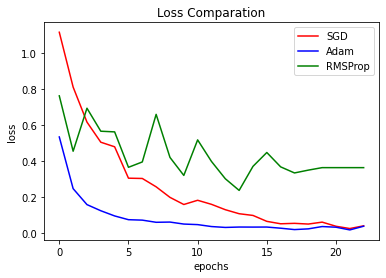

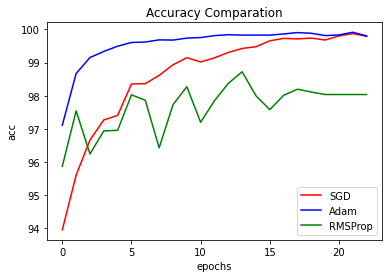

In [20]:
  plot_results_2(4, 5, loss3, loss4, loss5, acc3, acc4, acc5, "SGD", "Adam", "RMSProp")

Observación: el eje de las abscisas debe ser interpretado como n_real_epochs = epochs*3, pues se entrenó con reports_every = 3 para evitar esperas excesivamente largas y/o problemas de memoria.

En primer lugar es necesario mencionar que el valor que se escoja para el learning rate puede ser determinante en la superioridad de un optimizador sobre sus pares en los gráficos anteriores. Acá estudiaremos el caso con learning rate = 0.001 y notaremos que el optimizador con mejores resultados es Adam. Sin embargo, si se utilizan valores de learning rate más pequeños (como por ejemplo, 1e-5) se puede obtener que el mejor es SGD. En general, la elección de dicha variable debe realizarse de forma empírica y basándose en distintos factores, que incluyen el tiempo de entrenamiento necesario para alcanzar cierta precisión mínima (Véase https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2). Para esta parte, sin embargo, se escogió un valor que fuera relativamente bueno para todos los optimizadores, a fin de poder compararlos en condiciones lo más justas posibles.

In [32]:
print("---==REPORTE MEJORES VALORES==---")
print("Mejor acierto con SGD: " + str(max(acc3)))
print("Mejor acierto con Adam: " + str(max(acc4)))
print("Mejor acierto con RMSProp: " + str(max(acc5)))
print("Mejor loss en test con SGD: " + str(min(loss3)))
print("Mejor loss en test con Adam: " + str(min(loss4)))
print("Mejor loss en test con RMSProp: " + str(min(loss5)))

print("\n\n---==REPORTE VALORES INICIALES==---")
print("Primer acierto con SGD: " + str(acc3[0]))
print("Primer acierto con Adam: " + str(acc4[0]))
print("Primer acierto con RMSProp: " + str(acc5[0]))
print("Primer loss en test con SGD: " + str(loss3[0]))
print("Primer loss en test con Adam: " + str(loss4[0]))
print("Primer loss en test con RMSProp: " + str(loss5[0]))


---==REPORTE MEJORES VALORES==---
Mejor acierto con SGD: 99.87333333333333
Mejor acierto con Adam: 99.915
Mejor acierto con RMSProp: 98.72333333333333
Mejor loss en test con SGD: tensor(0.0233, device='cuda:0')
Mejor loss en test con Adam: tensor(0.0157, device='cuda:0')
Mejor loss en test con RMSProp: tensor(0.2352, device='cuda:0')


---==REPORTE VALORES INICIALES==---
Primer acierto con SGD: 93.95333333333333
Primer acierto con Adam: 97.11166666666666
Primer acierto con RMSProp: 95.87166666666667
Primer loss en test con SGD: tensor(1.1138, device='cuda:0')
Primer loss en test con Adam: tensor(0.5321, device='cuda:0')
Primer loss en test con RMSProp: tensor(0.7605, device='cuda:0')


Como introducimos en el párrafo anterior, los gráficos obtenidos nos permiten afirmar que para el problema tratado, la red implementada y los hiperparámetros asignados, los mejores resultados se obtienen a través del optimizador Adam. Las razones son varias:


1.   El acierto comienza en valores considerablemente más altos que con sus pares RMSProp y SGD: 97.11% contra 93.95% y 95.87%, aproximadamente.
2.   Similar al punto anterior, la pérdida comienza en valores más bajos que con sus pares: 0.53 contra 0.76 y 1.11, aproximadamente. 
3.   La convergencia con Adam es mucho más rápida que con su par más competente, SGD: mientras Adam alcanza un 99.80% de acierto en aproximadamente 30 épocas, SGD lo hace en más de 45.
4.   Con RMSProp, por otra parte, no se supera el 98.73% de acierto (tras lo cual comienza el overfitting con una variación considerable entre cada reporte).
5.  El mejor acierto alcanzado con Adam es mayor que el alcanzado con sus pares: 99.92% para Adam contra 99.87% y 98.72% para SGD y RMSProp, respectivamente.


Por los puntos anteriores, la elección correcta pareciese evidente. Sin embargo, hay cierto detalle que puede agregarle complejidad: Si observamos con detención la curva de accuracy para la red con SGD, notaremos que se mantuvo creciente hasta el final del entrenamiento, mientras que la curva de Adam pareciese haber alcanzado un punto de no crecimiento hacia la mitad del entrenamiento, manteniéndose ahí por algunas épocas y luego haber comenzado a sufrir un leve overfitting. Esto nos lleva a formar el supuesto de que, probablemente, al aumentar aún más el número de épocas podría conseguirse un accuracy mayor al mejor encontrado con Adam mediante SGD. Sin embargo, ello tomaría mucho tiempo y recursos, dos factores que podríamos desear mantener relativamente bajos. 

Desde luego, el tiempo de convergencia y la fiabilidad de las predicciones en épocas tempranas son factores que podrían ser tanto o más determinantes en la elección de nuestro optimizador, y si con Adam estamos ganando eso y además llegando a un 99.92% de acierto en una cantidad reducida de épocas, podría no interesarnos demasiado conseguir (quizá) ese 0.08% restante mediante SGD.  Pero ello dependerá de la naturaleza misma del problema y lo que resulte más importante para el usuario: obtener valores relativamente confiables en tiempos reducidos, u obtener valores tan altos  como sea posible sin importar demasiado el tiempo que la red tarde en lograrlos. 


Lo anterior nos permite afirmar que, en general, la elección del optimizador a usar influirá ampliamente en el tiempo de convergencia de la red y el acierto alcanzado. La prueba más clara de lo primero es la diferencia entre Adam y SGD, mientras que para lo segundo basta comparar RMSProp con cualquiera de sus pares. Generalizar los resultados más allá (como por ejemplo, afirmando que Adam es el mejor de los 3 siempre) es algo arriesgado, pues hay una serie amplia de factores que pueden incidir en ello, incluida la naturaleza misma del problema y los hiperparámetros que se escojan, por lo cual nos limitaremos a concluir que, para el problema tratado en este apartado, es recomendable usar Adam por sobre SGD y RMSProp, en especial si interesa obtener un buen valor de acierto tempranamente (y no tanto llegar a un 100%, en cuyo caso recomendaríamos intentarlo con SGD y una gran cantidad de épocas ~100).


Algo interesante que mencionamos rápidamente sobre la curva de Adam es el hecho de que el mejor acierto no se alcanza hacia el final del entrenamiento si no algunas épocas antes, momento a partir del cual no se vuelve a presentar. Esto no es una coincidencia, y lo veremos en la sección a continuación.




Algunos artículos en los cuales nos basamos para formular las observaciones anteriores: 
1. https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
2. https://medium.com/syncedreview/iclr-2019-fast-as-adam-good-as-sgd-new-optimizer-has-both-78e37e8f9a34




---



Nos interesará tambien comparar las estrategias de inicialización implementadas. En particular, compararemos los resultados en testing de inicializar una misma red con pesos aleatorios y con inicialización de Xavier-He, utilizando el mismo optimizador Adam que se encontró en la parte anterior.

In [21]:
mnist_model_6 = FFNN(784, [1024, 2048, 512], [relu, relu, relu], 10, keep_prob=[1.0, 0.8, 0.8, 1.0], init='xavier')
Adam_optimizer = Adam(mnist_model_6.parameters(), lr=0.001, epsilon=1e-8)

with torch.no_grad():
  loss6, acc6 = entrenar_FFNN(mnist_model_6, mnist_train_dataset, Adam_optimizer, epochs = 45, batch_size=32, device='cuda', reports_every=3)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Epoch:045 Acc:99.47% Loss:0.0952 Tiempo/epoch:17.014s

In [22]:
mnist_model_7 = FFNN(784, [1024, 2048, 512], [relu, relu, relu], 10, keep_prob=[1.0, 0.8, 0.8, 1.0])
Adam_optimizer = Adam(mnist_model_7.parameters(), lr=0.001, epsilon=1e-8)

with torch.no_grad():
  loss7, acc7 = entrenar_FFNN(mnist_model_7, mnist_train_dataset, Adam_optimizer, epochs = 45, batch_size=32, device='cuda', reports_every=3)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Epoch:045 Acc:99.85% Loss:0.0276 Tiempo/epoch:16.659s

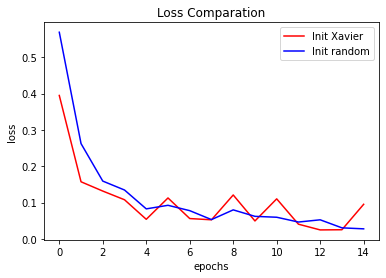

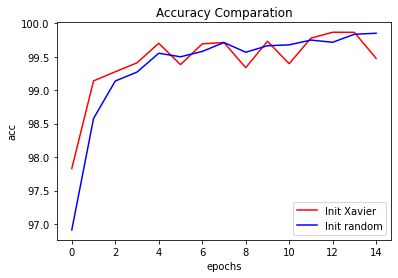

In [27]:
plot_results_2(6, 7, loss6, loss7, None, acc6, acc7, None, "Init Xavier", "Init random")

Observamos que para una misma configuración de red y optimizador, la inicialización por el método de Xavier-He permite llegar a un acierto sobre el 99.75% en una cantidad de épocas menor a la necesaria cuando se usa una inicialización con valores aleatorios: mientras el primero lo logra entre las épocas 12 y 15, el segundo requiere de al menos 21 épocas para alcanzar dicho valor.  

Notamos también que con la inicialización de Xavier-He la red entrega predicciones iniciales mucho mejores que aquellas obtenidas mediante la inicialización aleatoria: con el primer método, las predicciones comienzan en aproximadamente un 98% de acierto y con un 0.4 de pérdida, mientras que con inicialización aleatoria dichos valores se reemplazan por 97% y 0.6, correspondientemente. 

Una observación adicional que se desprende de los gráficos - y que guarda relación con el fenómeno que describíamos hacia el final de la sección anterior - es la importancia del early stopping. Si bien en la parte anterior la mayoría de las curvas tendian a un valor en el que permanecían casi estáticamente, notamos que tras cierto punto la curva de Adam no volvió a superar un máximo anterior. Esto se debe a que, frecuentemente, el continuar entrenando más allá de cierto punto da origen a una serie de cambios bruscos y desfavorables, conocidos como overfitting. Esto es particularmente notorio con las curvas de Loss y Accuracy obtenidas al utilizar la inicialización de Xavier-He, que tras alcanzar por primera vez un valor cercano a su máximo comienza a alternar entre valores levemente mayores y otros considerablemente menores en una especie de 'zig-zag'. En general buscaremos evitar esto, pues puede guiarnos a situaciones desfavorables: 
  1. Que el entrenamiento termine con el valor más bajo del zig-zag, quedándonos con una red que ''podría ser mejor''. 
  2. Que el zig-zag de origen a una caída irremediable en el acierto, lo cual se puede generar tras pasar por muchas épocas de overfitting (las pruebas con este problema mostraron que entrenar por más de 60 épocas entrega aciertos levemente mejores que un clasificador aleatorio, rondando el 15%). El problema acá es obvio: terminaríamos con una red prácticamente inútil.

# Parte 3 (Opcional): Batch Normalization

In [ ]:
# Tu código debiera continuar como sigue

class FFNN():
  def __init__(self, F, l_h, l_a, C, keep_prob=None, bn=None):
    # debes crear los parámetros necesarios para las capas de
    # batch normalizacion
    pass
  
  def forward(x, predict=False):
    # debes modificar esta función para considerar las capas para las que se
    # usará batch normalization
    # también debes preocuparte de guardar los datos estadísticos que se
    # usaran en tiempo de test (predict=True)
    pass
  
  def backward(x,y,y_pred):
    # computar acá todos los gradientes considerando las capas de 
    # batch normalization
    # no olvides considerar los nuevos parámetros entrenables.
    pass